In [ ]:
!git clone https://github.com/ikhsan-kun/dataset-banana-leaf.git

fatal: destination path 'dataset-banana-leaf' already exists and is not an empty directory.


In [ ]:
!rm -rf dataset-banana-leaf/.git

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Untuk membagi data secara manual
import shutil # Untuk operasi file/folder

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# Konfigurasi Dasar
DATA_DIR = '/content/dataset-banana-leaf'
IMG_HEIGHT = 320
IMG_WIDTH = 320
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.2
SEED = 42 # Untuk reproduktifitas hasil

In [ ]:
# Persiapan Dataset
all_image_paths = []
all_labels = []
if not os.path.isdir(DATA_DIR):
    print(f"Error: Direktori '{DATA_DIR}' tidak ditemukan.")
    print("Pastikan folder ini ada dan berada di lokasi yang sama dengan skrip Anda.")
    exit()

class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
num_classes = len(class_names)

if num_classes == 0:
    print(f"Error: Tidak ada sub-folder (kategori makanan) ditemukan di '{DATA_DIR}'.")
    print("Pastikan struktur folder Anda seperti 'dataset-banana-leaf/banana healthy leaf/', dll.")
    exit()

print(f"Ditemukan {num_classes} kategori: {class_names}")

label_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            all_image_paths.append(os.path.join(class_dir, img_name))
            all_labels.append(label_to_index[class_name])

if not all_image_paths:
    print(f"Error: Tidak ada gambar ditemukan di '{DATA_DIR}'. Pastikan gambar berada di dalam sub-folder kategori.")
    exit()

print(f"Total gambar yang ditemukan: {len(all_image_paths)}")

Ditemukan 12 kategori: ['Banana Black Sigatoka Disease', 'Banana Bract Mosaic Virus Disease', 'Banana Healthy Leaf', 'Banana Insect Pest Disease', 'Banana Moko Disease', 'Banana Panama Disease', 'Banana Yellow Sigatoka Disease', 'banana fusarium wilt', 'banana natural death leaf', 'banana rhizome_root', 'batang_sehat', 'tunggul_sehat']
Total gambar yang ditemukan: 1254


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

MIN_PER_CLASS = 300

# Hitung jumlah gambar per kelas
class_counts = {label: 0 for label in label_to_index.values()}
for label in all_labels:
    class_counts[label] += 1

# Buat label ke nama folder
index_to_label = {v: k for k, v in label_to_index.items()}

# Loop tiap label
for label in class_counts:
    count = class_counts[label]
    if count >= MIN_PER_CLASS:
        continue  # skip kalau sudah cukup

    need = MIN_PER_CLASS - count
    class_name = index_to_label[label]
    class_paths = [p for p, l in zip(all_image_paths, all_labels) if l == label]

    # Tambahkan pemeriksaan ini untuk mencegah IndexError jika class_paths kosong
    if not class_paths:
        print(f"Peringatan: Tidak ada gambar ditemukan untuk kelas '{class_name}'. Melewati augmentasi.")
        continue

    print(f"Melakukan augmentasi {need} gambar untuk kelas '{class_name}'...")

    for i in range(need):
        src_path = random.choice(class_paths)
        img_raw = tf.io.read_file(src_path)
        img = tf.image.decode_image(img_raw, channels=3)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = tf.cast(img, tf.float32) / 255.0

        # Apply augmentasi
        aug = data_augmentation(tf.expand_dims(img, 0), training=True)
        aug = tf.squeeze(aug, 0).numpy()
        aug = (aug * 255).astype(np.uint8)

        # Simpan hasil
        filename = f"aug_{i}_{os.path.basename(src_path)}"
        save_path = os.path.join(DATA_DIR, class_name, filename)
        Image.fromarray(aug).save(save_path)

Melakukan augmentasi 233 gambar untuk kelas 'Banana Black Sigatoka Disease'...
Melakukan augmentasi 250 gambar untuk kelas 'Banana Bract Mosaic Virus Disease'...
Melakukan augmentasi 214 gambar untuk kelas 'Banana Healthy Leaf'...
Melakukan augmentasi 214 gambar untuk kelas 'Banana Insect Pest Disease'...
Melakukan augmentasi 245 gambar untuk kelas 'Banana Moko Disease'...
Melakukan augmentasi 259 gambar untuk kelas 'Banana Panama Disease'...
Melakukan augmentasi 277 gambar untuk kelas 'Banana Yellow Sigatoka Disease'...
Melakukan augmentasi 190 gambar untuk kelas 'banana natural death leaf'...
Melakukan augmentasi 190 gambar untuk kelas 'banana rhizome_root'...
Melakukan augmentasi 156 gambar untuk kelas 'batang_sehat'...
Melakukan augmentasi 192 gambar untuk kelas 'tunggul_sehat'...


In [ ]:
# Membaca ulang dataset setelah augmentasi
all_image_paths = []
all_labels = []
for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            all_image_paths.append(os.path.join(class_dir, img_name))
            all_labels.append(label_to_index[class_name])

print(f"Total gambar setelah augmentasi: {len(all_image_paths)}")

Total gambar setelah augmentasi: 3674


In [ ]:
# Bagi data menjadi training dan validation set
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=VALIDATION_SPLIT, random_state=SEED, stratify=all_labels
)

print(f"Jumlah gambar training: {len(train_paths)}")
print(f"Jumlah gambar validation: {len(val_labels)}")

Jumlah gambar training: 2939
Jumlah gambar validation: 735


In [ ]:
# Fungsi untuk memuat dan pra-proses gambar
def load_and_preprocess_image(image_path_tensor, label_tensor, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = tf.io.read_file(image_path_tensor)
    img = tf.image.decode_jpeg(img, channels=3) # Sesuaikan jika ada PNG: tf.image.decode_image
    img = tf.image.resize(img, target_size)
    img = img / 255.0
    return img, label_tensor

In [ ]:
# Membuat TensorFlow Dataset
train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(train_paths), tf.constant(train_labels, dtype=tf.int32)))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((tf.constant(val_paths), tf.constant(val_labels, dtype=tf.int32)))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("\nDataset berhasil dibuat.")


Dataset berhasil dibuat.


In [ ]:
# Membangun Model
print("Membangun model...")
base_model = applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                     include_top=False,
                                     weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Membangun model...


/tmp/ipython-input-391781663.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,500 (9.24 MB)

 Trainable params: 165,516 (646.55 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Membuat fungsi callback
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
]

In [ ]:
# Kompilasi model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

print("\nMemulai pelatihan model...")

# Melatih Model
history = model.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds
)

print("\nPelatihan selesai.")


Memulai pelatihan model...
Epoch 1/40
368/368 ━━━━━━━━━━━━━━━━━━━━ 72s 117ms/step - accuracy: 0.7447 - loss: 0.8122 - val_accuracy: 0.9660 - val_loss: 0.1091
Epoch 2/40
368/368 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9643 - loss: 0.0954 - val_accuracy: 0.9769 - val_loss: 0.0694
Epoch 3/40
368/368 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9891 - loss: 0.0487 - val_accuracy: 0.9837 - val_loss: 0.0495
Epoch 4/40
368/368 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9894 - loss: 0.0335 - val_accuracy: 0.9810 - val_loss: 0.0470
Epoch 5/40
368/368 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9914 - loss: 0.0245 - val_accuracy: 0.9891 - val_loss: 0.0352
Epoch 6/40
368/368 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9910 - loss: 0.0341 - val_accuracy: 0.9850 - val_loss: 0.0452
Epoch 7/40
368/368 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9845 - loss: 0.0456 - val_accuracy: 0.9769 - val_loss: 0.0628
Epoch 8/40
368/368 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accur

### Menguji Model dengan Gambar Baru

Mengumpulkan prediksi untuk evaluasi model...
Prediksi berhasil dikumpulkan.
Menguji gambar yang salah diklasifikasikan: /content/dataset-banana-leaf/Banana Black Sigatoka Disease/aug_222_Black Sigatoka Disease (65).jpg
Label Sebenarnya: Banana Black Sigatoka Disease
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


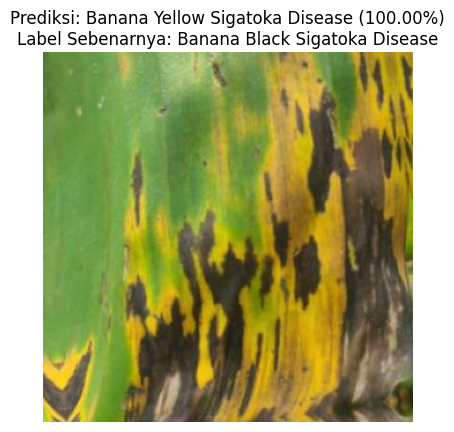

Gambar diprediksi sebagai: Banana Yellow Sigatoka Disease dengan probabilitas 100.00%


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Fungsi untuk memuat dan pra-proses gambar baru
def preprocess_new_image(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array = img_array / 255.0  # Normalisasi
    return img_array

# Check if y_true, y_pred_classes, and misclassified_indices are already defined
# If not, calculate them to ensure the testing block can run.
if 'y_true' not in locals() or 'y_pred_classes' not in locals() or 'misclassified_indices' not in locals():
    print("Mengumpulkan prediksi untuk evaluasi model...")
    y_true = []
    y_pred_probs = []

    # Iterate through the validation dataset to get true labels and predictions
    for images, labels in val_ds.unbatch():
        y_true.append(labels.numpy())
        # Expand dimensions to create a batch of 1 image for prediction
        img_batch = tf.expand_dims(images, axis=0)
        y_pred_probs.append(model.predict(img_batch, verbose=0)[0]) # verbose=0 to suppress output for each prediction

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred_classes = np.argmax(y_pred_probs, axis=1) # Get the index of the highest probability
    misclassified_indices = np.where(y_true != y_pred_classes)[0]
    print("Prediksi berhasil dikumpulkan.")

# Path ke gambar baru yang ingin diuji
# Anda bisa mengganti ini dengan path gambar dari dataset Anda atau gambar lain
# Contoh: Ambil satu gambar dari validation set yang benar diklasifikasikan
if len(misclassified_indices) > 0:
    # Ambil gambar pertama yang salah diklasifikasikan
    test_image_path = val_paths[misclassified_indices[0]]
    true_label_name = class_names[y_true[misclassified_indices[0]]]
    print(f"Menguji gambar yang salah diklasifikasikan: {test_image_path}")
    print(f"Label Sebenarnya: {true_label_name}")
else:
    # Atau ambil gambar acak dari validation set
    random_index = random.randint(0, len(val_paths) - 1)
    test_image_path = val_paths[random_index]
    true_label_name = class_names[y_true[random_index]]
    print(f"Menguji gambar acak dari validasi set: {test_image_path}")
    print(f"Label Sebenarnya: {true_label_name}")

# Pra-proses gambar
preprocessed_image = preprocess_new_image(test_image_path)

# Lakukan prediksi
predictions = model.predict(preprocessed_image)

# Dapatkan label kelas dengan probabilitas tertinggi
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]
confidence = predictions[0][predicted_class_index] * 100

# Tampilkan gambar dan hasil prediksi
plt.imshow(Image.open(test_image_path))
plt.title(f"Prediksi: {predicted_class_name} ({confidence:.2f}%)\nLabel Sebenarnya: {true_label_name}")
plt.axis('off')
plt.show()

print(f"Gambar diprediksi sebagai: {predicted_class_name} dengan probabilitas {confidence:.2f}%")


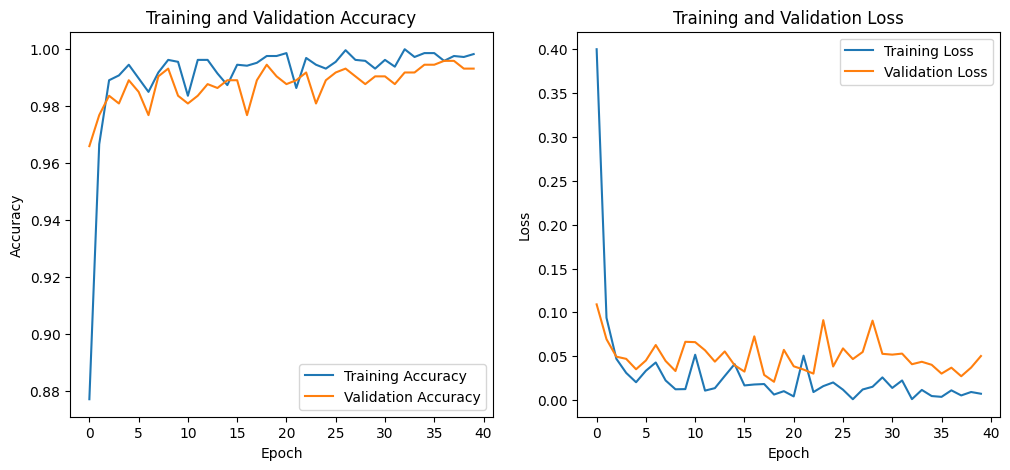

In [ ]:
# Visualisasi Hasil Pelatihan
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluasi Mendalam Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns # Untuk visualisasi confusion matrix
import matplotlib.image as mpimg

print("\n--- Evaluasi Mendalam Model ---")

# 1. Mengumpulkan Prediksi dan Label Sebenarnya dari Validation Set
y_true = []
y_pred_probs = [] # menyimpan probabilitas prediksi

for images, labels in val_ds.unbatch():
    y_true.append(labels.numpy())
    img_batch = tf.expand_dims(images, axis=0)
    y_pred_probs.append(model.predict(img_batch)[0])

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # mengambil ideks prob tertinggi


--- Evaluasi Mendalam Model ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━

In [ ]:
import numpy as np
# Classification Report
print("\nClassification Report:")
# Filter out '.git' from class_names and get unique labels from y_true
filtered_class_names = [name for name in class_names if name != '.git']
actual_labels = np.unique(y_true)

print(classification_report(y_true, y_pred_classes, target_names=filtered_class_names, labels=actual_labels))


Classification Report:
                                   precision    recall  f1-score   support

    Banana Black Sigatoka Disease       0.95      0.97      0.96        60
Banana Bract Mosaic Virus Disease       1.00      1.00      1.00        60
              Banana Healthy Leaf       1.00      1.00      1.00        60
       Banana Insect Pest Disease       1.00      0.97      0.98        60
              Banana Moko Disease       1.00      1.00      1.00        60
            Banana Panama Disease       1.00      1.00      1.00        60
   Banana Yellow Sigatoka Disease       0.97      0.98      0.98        60
             banana fusarium wilt       1.00      1.00      1.00        75
        banana natural death leaf       1.00      1.00      1.00        60
              banana rhizome_root       1.00      1.00      1.00        60
                     batang_sehat       1.00      1.00      1.00        60
                    tunggul_sehat       1.00      1.00      1.00        60



Membuat Confusion Matrix...


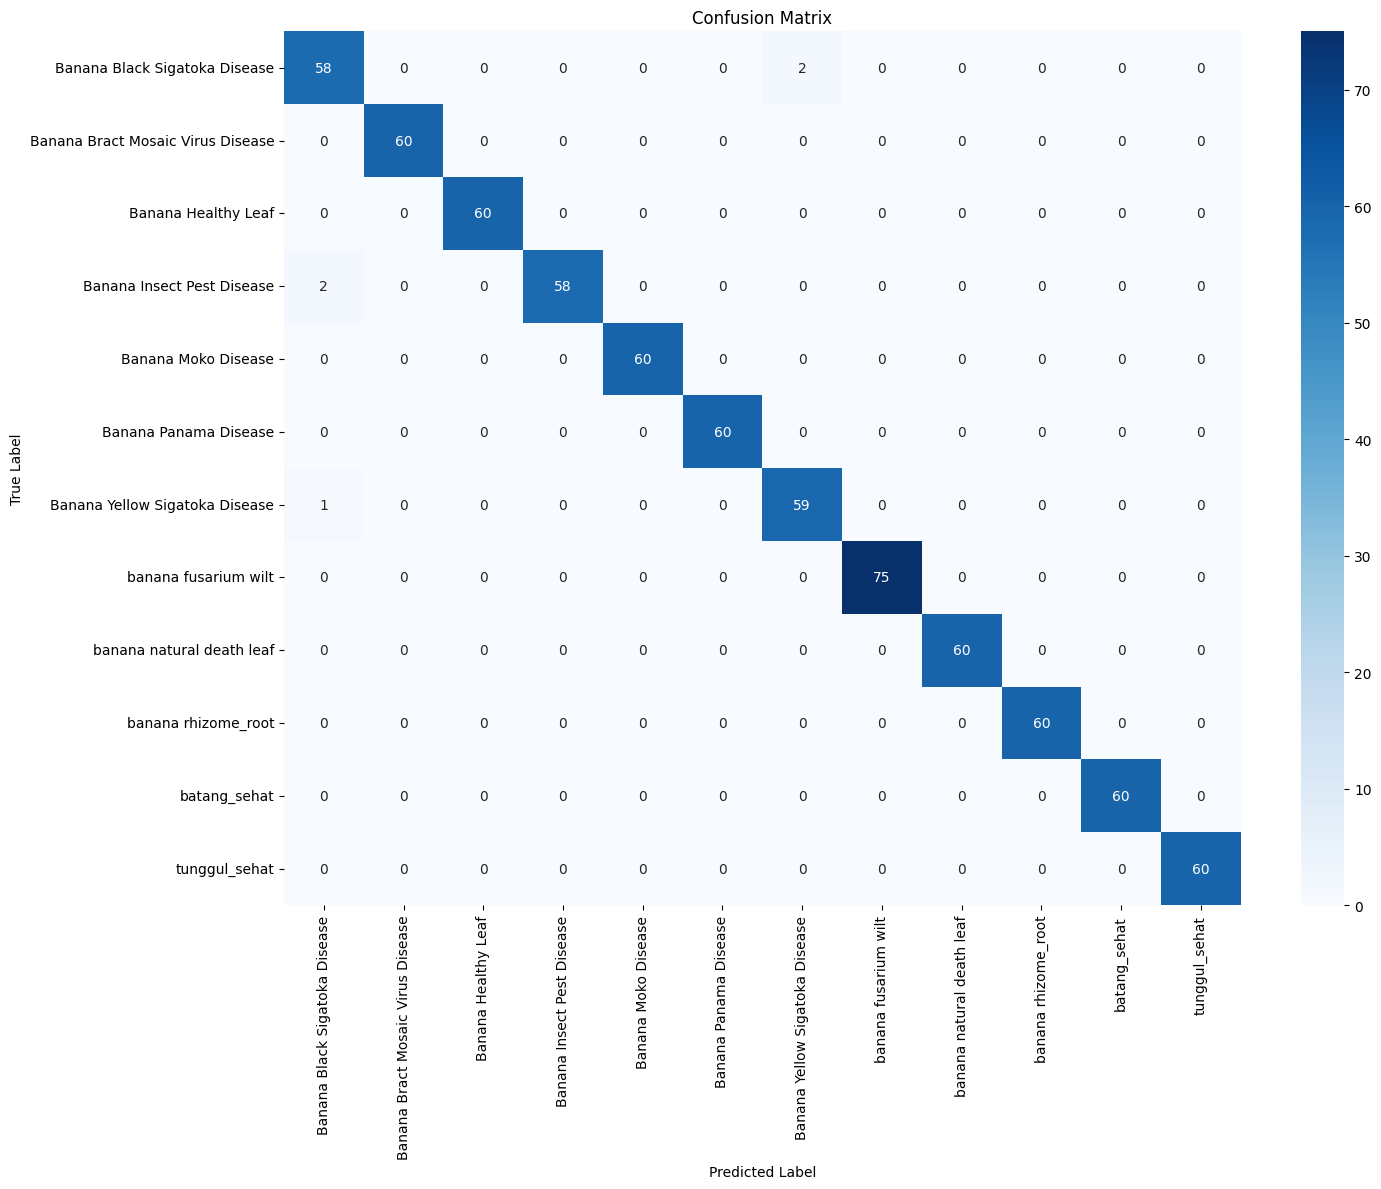

In [ ]:
# Visualisasi Confusion Matrix
print("\nMembuat Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


--- Analisis Contoh Kesalahan ---
Mencari contoh gambar yang salah diklasifikasikan...
Ditemukan 5 gambar yang salah diklasifikasikan.


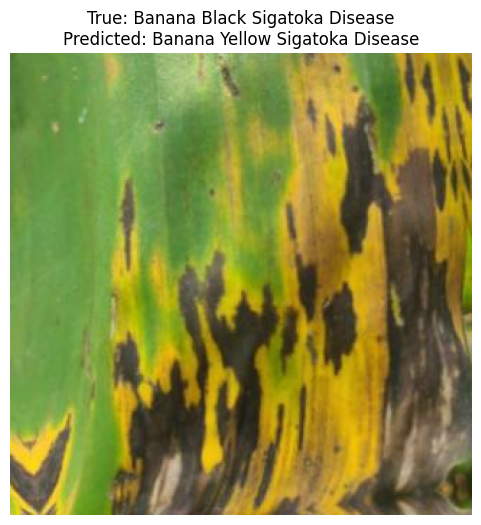

Gambar: /content/dataset-banana-leaf/Banana Black Sigatoka Disease/aug_222_Black Sigatoka Disease (65).jpg
True: Banana Black Sigatoka Disease, Predicted: Banana Yellow Sigatoka Disease



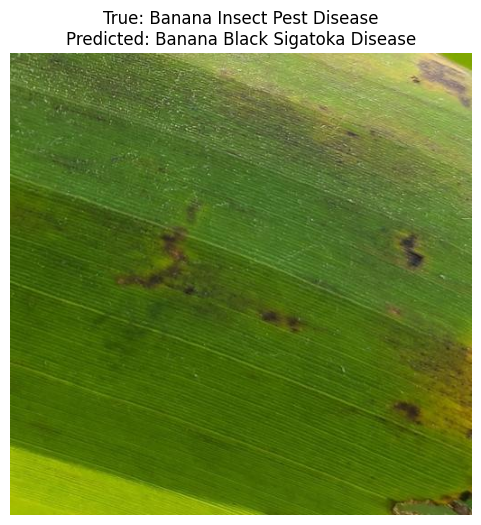

Gambar: /content/dataset-banana-leaf/Banana Insect Pest Disease/Insect Pest Disease (45).jpg
True: Banana Insect Pest Disease, Predicted: Banana Black Sigatoka Disease



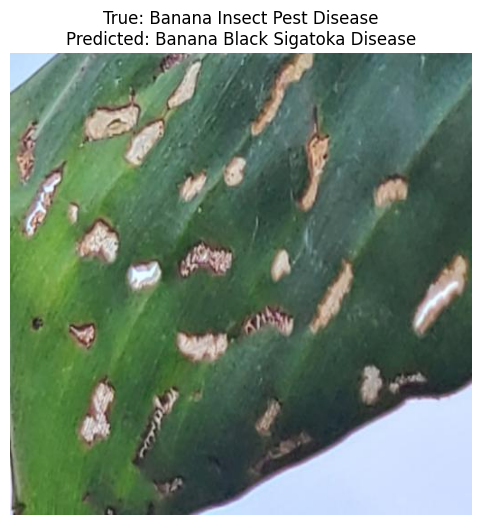

Gambar: /content/dataset-banana-leaf/Banana Insect Pest Disease/Insect Pest Disease (41).jpg
True: Banana Insect Pest Disease, Predicted: Banana Black Sigatoka Disease



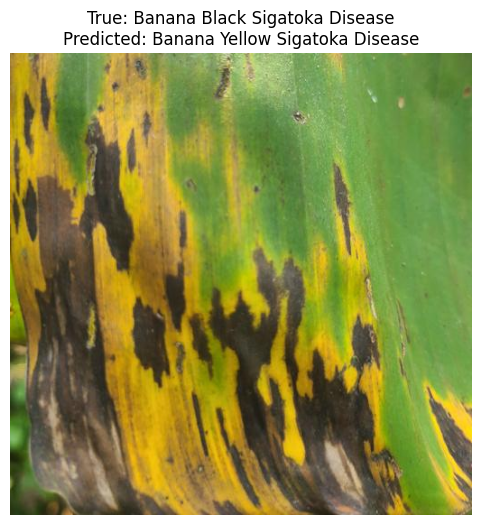

Gambar: /content/dataset-banana-leaf/Banana Black Sigatoka Disease/Black Sigatoka Disease (65).jpg
True: Banana Black Sigatoka Disease, Predicted: Banana Yellow Sigatoka Disease



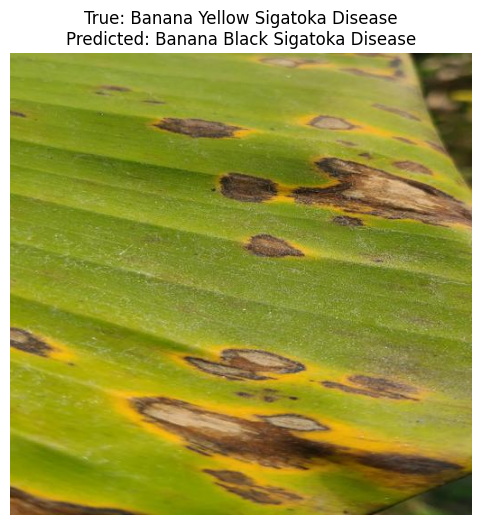

Gambar: /content/dataset-banana-leaf/Banana Yellow Sigatoka Disease/Yellow Sigatoka Disease (7).jpg
True: Banana Yellow Sigatoka Disease, Predicted: Banana Black Sigatoka Disease



In [ ]:
# Analisis Contoh Kesalahan ML
print("\n--- Analisis Contoh Kesalahan ---")
print("Mencari contoh gambar yang salah diklasifikasikan...")

# Dapatkan indeks gambar yang salah diklasifikasikan
misclassified_indices = np.where(y_true != y_pred_classes)[0]

if len(misclassified_indices) > 0:
    print(f"Ditemukan {len(misclassified_indices)} gambar yang salah diklasifikasikan.")
    # Tampilkan beberapa contoh
    num_display_errors = min(5, len(misclassified_indices)) # Tampilkan maksimal 5 kesalahan

    error_paths = []
    error_true_labels = []
    error_predicted_labels = []

    for i in range(num_display_errors):
        idx_in_val_set = misclassified_indices[i]
        original_path = val_paths[idx_in_val_set]
        true_label = class_names[y_true[idx_in_val_set]]
        predicted_label = class_names[y_pred_classes[idx_in_val_set]]

        plt.figure(figsize=(6, 6))
        img = mpimg.imread(original_path)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis('off')
        plt.show()
        print(f"Gambar: {original_path}\nTrue: {true_label}, Predicted: {predicted_label}\n")

else:
    print("Tidak ada gambar yang salah diklasifikasikan di validation set!")

### Prediksi dengan Gambar yang Diunggah Secara Manual

Saving download (1).jpg to download (1).jpg
User uploaded file "download (1).jpg" with length 3563 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


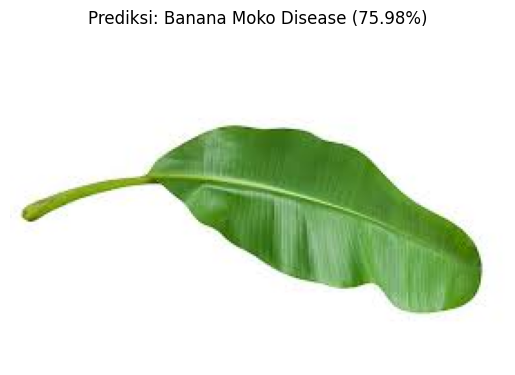

Gambar diprediksi sebagai: Banana Moko Disease dengan probabilitas 75.98%


In [ ]:
from google.colab import files
import io

# Meminta pengguna untuk mengunggah file gambar
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    # Memuat gambar dari file yang diunggah
    img_bytes = uploaded[fn]
    img = Image.open(io.BytesIO(img_bytes))

    # Pra-proses gambar
    preprocessed_image = preprocess_new_image(io.BytesIO(img_bytes)) # Pass bytes to preprocess function

    # Lakukan prediksi
    predictions = model.predict(preprocessed_image)

    # Dapatkan label kelas dengan probabilitas tertinggi
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"Gambar diprediksi sebagai: {predicted_class_name} dengan probabilitas {confidence:.2f}%")


In [ ]:
# Menguji Model dan Melihat Persentase Keberhasilan
print(f"\nEvaluasi pada data validasi:")
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Persentase Keberhasilan (Validation Accuracy): {val_accuracy*100:.2f}%")


Evaluasi pada data validasi:
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9893 - loss: 0.0310
Validation Loss: 0.0199
Persentase Keberhasilan (Validation Accuracy): 99.32%


In [ ]:
# Menyimpan model dalam format HDF5
save_path = 'model.h5'
model.save(save_path)

In [ ]:
# Menyimpan model dalam format h5
model.save('model.h5')

In [ ]:
# Menyimpan model dalam tensoflow.js
!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve saved_model tfjs_model

2025-12-08 07:06:11.394733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765177571.414104   10211 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765177571.420232   10211 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765177571.435192   10211 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765177571.435217   10211 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765177571.435221   10211 computation_placer.cc:177] computation placer alr

In [ ]:
# Menyimpan model dalam tensorflow lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpv1le41mb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  138261728136272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261728144528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261728144720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261728143952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261728143184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261728142992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261728146448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261728146640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261728145488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261728143760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138261728